In [263]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder


train = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/train.csv")
test = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/test.csv")

extra_params = {"feature_tools" : 1, "undersampling" : 0, "oversampling" : 1, "drop_cat_vars" : 0, "date_column" : 1, "corr_thresh" : 0.9}

### Division of Sets

In [264]:
X = train.drop(columns = "target")
y = train["target"]

In [265]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [266]:
X_train['target'] = y_train
X_val['target'] = y_val

In [267]:
train = X_train.copy()
val = X_val.copy()

In [268]:
#Keep average cost min
averagecostmin = val['average cost min']
idtest = test["id"]

### Initial Exploration

In [269]:
train.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,...,4032.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,31.414126,33.699347,2.673358,238.945229,708.792184,104.036431,311.938372,16.322677,50.079971,169.551549,...,10.081397,19.133955,73.501256,186.803427,0.168306,0.609716,0.327824,0.061717,0.162328,0.146716
std,12.775443,14.007828,3.418703,239.288923,503.929355,97.260823,199.167646,16.296733,36.092455,141.787096,...,2.108023,27.987193,60.000356,82.079489,0.077812,0.224430,0.209932,0.063644,0.105643,0.353867
min,12.000000,9.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.300000,0.000000,59.000000,307.500000,28.000000,149.550000,4.000000,22.800000,64.261044,...,8.573250,0.000000,32.134081,123.802373,0.134413,0.466317,0.165139,0.020942,0.078918,0.000000
50%,29.000000,33.666667,1.000000,161.000000,614.400001,73.000000,291.000000,11.000000,44.399999,132.279506,...,9.518597,7.515854,57.801016,173.254831,0.154525,0.654877,0.287722,0.043932,0.157734,0.000000
75%,39.000000,45.933333,2.000000,343.000000,1014.300000,156.000000,446.400000,24.000000,71.750000,236.853610,...,11.696253,28.308661,99.217719,232.116107,0.179302,0.782261,0.458395,0.080924,0.244154,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,106.000000,205.000000,935.947864,...,21.734694,184.892166,437.063835,587.063835,1.357564,1.000000,1.000000,0.731884,2.601223,1.000000


In [270]:
train.describe(include = 'object')

,Gender,Connect_Date,tariff,Handset,Usage_Band,Tariff_OK,high Dropped calls,No Usage,id
count,4035,4035,4035,4035,4032,4035,4035,4035,4035
unique,2,1310,5,11,5,4,2,2,4035
top,F,11/07/1999,CAT 200,S50,Med,OK,F,F,K277140
freq,2042,11,1802,944,2232,4006,3933,4032,1


Drop ID (too many unique values), No Usage (Only has False Values)

In [271]:
train = train.drop(columns = ["id", "No Usage"])
val = val.drop(columns = ["id", "No Usage"])
test = test.drop(columns = ["id", "No Usage"])

### Preprocessing

#### Feature Engineering

In [272]:
if extra_params["date_column"] == 1:
    train["Connect_Date"] = train["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    test["Connect_Date"] = test["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    val["Connect_Date"] = val["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    
    max_train = train["Connect_Date"].max()
    max_test = test["Connect_Date"].max()
    max_val = val["Connect_Date"].max()

    train["End_Date"] = max_train
    test["End_Date"] = max_test
    val["End_Date"] = max_val

    train["Connect_Time"] = train["End_Date"] - train["Connect_Date"]
    test["Connect_Time"] = test["End_Date"] - test["Connect_Date"]
    val["Connect_Time"] = val["End_Date"] - val["Connect_Date"]

    train["Connect_Time"] = train["Connect_Time"].apply(lambda x : x.days)
    test["Connect_Time"] = test["Connect_Time"].apply(lambda x : x.days)
    val["Connect_Time"] = val["Connect_Time"].apply(lambda x : x.days)

    train = train.drop(columns = ["End_Date"])
    test = test.drop(columns = ["End_Date"])
    val = val.drop(columns = ["End_Date"])

train = train.drop(columns = ["Connect_Date"])
test = test.drop(columns = ["Connect_Date"])
val = val.drop(columns = ["Connect_Date"])

#### Missing Values

In [273]:
train.isna().sum()

Gender                    0
Age                       0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls        0
target              

In [274]:
rows_with_missing_values = train[train.isnull().any(axis=1)]

In [275]:
rows_with_missing_values[["call_cost_per_min", "Dropped_calls_ratio", "Usage_Band"]]

,call_cost_per_min,Dropped_calls_ratio,Usage_Band
3836,NaN,NaN,NaN
4301,NaN,NaN,NaN
3237,NaN,NaN,NaN


Missing values are all in the same 3 rows. Since they're only 3 observations out of 4035, they're imputed using median imputation

##### Imputing Numerical Columns

In [276]:
# Assuming 'data' is your dataset with missing values
# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data
imputer.fit(train[["call_cost_per_min", "Dropped_calls_ratio"]])

# Transform the data by replacing missing values with the median
test_clean = imputer.transform(test[["call_cost_per_min", "Dropped_calls_ratio"]])
train_clean = imputer.transform(train[["call_cost_per_min", "Dropped_calls_ratio"]])
val_clean = imputer.transform(val[["call_cost_per_min", "Dropped_calls_ratio"]])

In [277]:
train["call_cost_per_min"] = train_clean[:, 0]
test["call_cost_per_min"] = test_clean[:, 0]
val["call_cost_per_min"] = val_clean[:, 0]

train["Dropped_calls_ratio"] = train_clean[:, 1]
test["Dropped_calls_ratio"] = test_clean[:, 1]
val["Dropped_calls_ratio"] = val_clean[:, 1]

##### Imputing Categorical Column

In [278]:
# Initialize the imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(np.array(train["Usage_Band"]).reshape(-1, 1))

train["Usage_Band"] = imputer.transform(np.array(train["Usage_Band"]).reshape(-1, 1))[:, 0]
test["Usage_Band"] = imputer.transform(np.array(test["Usage_Band"]).reshape(-1, 1))[:, 0]
val["Usage_Band"] = imputer.transform(np.array(val["Usage_Band"]).reshape(-1, 1))[:, 0]

#### Variable Selection

##### Dropping numerical variables that are useless

In [279]:
correlation_matrix = train[train.select_dtypes(include=['number']).columns.tolist()].corr()

In [280]:
corrtarget = correlation_matrix['target']

In [281]:
# Make plot for this

In [282]:
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > extra_params["corr_thresh"]:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))


In [283]:
high_correlation_pairs

[('L_O_S', 'Connect_Time'),
 ('Peak_calls_Sum', 'National_calls'),
 ('Peak_mins_Sum', 'National mins'),
 ('Peak_mins_Sum', 'All_calls_mins'),
 ('International_mins_Sum', 'Total_call_cost'),
 ('Nat_call_cost_Sum', 'actual call cost'),
 ('National mins', 'All_calls_mins'),
 ('All_calls_mins', 'Total_Cost'),
 ('Total_call_cost', 'Total_Cost'),
 ('Peak ratio', 'OffPeak ratio')]

In [284]:
def build_adjacency_list(pairs):
    adjacency_list = defaultdict(list)
    for u, v in pairs:
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

# Function to perform depth-first search (DFS) traversal to find connected components
def dfs(node, adjacency_list, visited, component):
    visited.add(node)
    component.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, adjacency_list, visited, component)

# Function to find connected components in the graph
def find_connected_components(pairs):
    adjacency_list = build_adjacency_list(pairs)
    visited = set()
    connected_components = []
    for node in adjacency_list:
        if node not in visited:
            component = []
            dfs(node, adjacency_list, visited, component)
            connected_components.append(component)
    return connected_components

# Find connected groups
connected_groups = find_connected_components(high_correlation_pairs)

In [285]:
def get_variables_to_drop(group, corrtarget):
    max_cor = 0
    var_max = ''
    for var in group:
        if abs(corrtarget[var]) > max_cor:
            var_max = var
    group.remove(var_max)

    return group

In [286]:
variables_to_drop = [get_variables_to_drop(group, corrtarget) for group in connected_groups]

In [287]:
drop_vars = [item for sublist in variables_to_drop for item in sublist]

In [288]:
train = train.drop(columns = drop_vars)

In [289]:
val = val.drop(columns = drop_vars)

In [290]:
test = test.drop(columns = drop_vars)

##### Deleting categorical variables that are useless

In [291]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [292]:
#Make plots for this

UsageBand, Tariff seem useless
Most useful inferences: High Dropped Calls seems a good indicator for whether someone will churn or not, ratio of Trues for churners is much higher. Tariff_Ok's High Cat 100 for churners is much higher than for non churners, would be good to add numerical encoding. Same for handset, numerical encoding would be nice. 

In [293]:
if extra_params["drop_cat_vars"] == 1:
    train = train.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    test = test.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    val = val.drop(columns = ["No Usage", "Usage_Band", "tariff"])

Outliers are not dealth with (they are useful in our detection, the higher the costs the bigger the probability of churning?)

#### Variable Transformation

##### Numerical Variables

In [294]:
test['target'] = 0

In [295]:
test

,Gender,Age,Dropped_Calls,tariff,Handset,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Tariff_OK,average cost min,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,Connect_Time,target
0,F,20.0,3.0,CAT 200,WC95,110.0,189.982227,8.0,5.017969,25.872662,...,8.933287,9.409262,OK,0.116924,0.173365,0.009823,0.020349,F,1314,0
1,F,54.0,0.0,Play 300,BS110,93.0,551.817423,8.0,17.593417,138.267040,...,11.931697,2.739423,OK,0.120457,0.532898,0.022391,0.124480,F,667,0
2,F,28.0,0.0,CAT 200,ASAD170,90.0,152.731006,10.0,23.907633,492.202970,...,9.560903,95.406158,OK,0.149435,0.034434,0.006660,0.225763,F,443,0
3,F,26.0,5.0,CAT 200,WC95,126.0,358.760706,0.0,3.024655,174.998124,...,8.398145,14.464628,OK,0.137372,0.263256,0.005870,0.108872,F,503,0
4,F,34.0,0.0,CAT 100,WC95,73.0,141.180280,11.0,47.034972,80.927142,...,12.766109,34.757126,OK,0.180704,0.166995,0.056390,0.090896,F,426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,F,32.0,0.0,CAT 200,BS110,8.0,42.952890,45.0,105.774031,86.262452,...,9.588439,35.396282,OK,0.122342,0.012611,0.070297,0.035339,F,921,0
1678,M,19.0,0.0,CAT 100,BS110,-1.0,73.643988,2.0,28.751955,56.083237,...,13.794174,30.518649,OK,0.163502,0.052157,0.041489,0.079988,F,366,0
1679,F,34.0,0.0,CAT 200,S50,21.0,278.414345,2.0,34.029118,188.224017,...,9.031387,96.373049,OK,0.127485,0.106429,0.011459,0.098248,F,1373,0
1680,M,21.0,2.0,CAT 100,BS110,76.0,196.742943,-1.0,18.472483,137.376495,...,11.898371,-0.223523,OK,0.205830,0.358159,0.017720,0.256554,F,1045,0


In [296]:
# List of numerical variable names
numerical_features = train.select_dtypes(include=['number']).columns.tolist()

# List of categorical variable names (replace with actual categorical variable names)
categorical_features = train.select_dtypes(exclude=['number']).columns.tolist()

# Define the transformers
transformers = [
    ('num', MinMaxScaler(), numerical_features)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

# Apply the column transformer to the data
transformed_train = preprocessor.fit_transform(train)
transformed_val = preprocessor.transform(val)
transformed_test = preprocessor.transform(test)


# Convert the transformed data back to DataFrame
transformed_train = pd.DataFrame(transformed_train, columns=numerical_features + categorical_features)
transformed_test = pd.DataFrame(transformed_test, columns=numerical_features + categorical_features)
transformed_val = pd.DataFrame(transformed_val, columns=numerical_features + categorical_features)



# Only the numerical variables will be scaled to the range [0, 1]

MinMaxScaling (0, 1)

MinMaxScaling (-1, 1)

Normalization + MinMaxScaling

##### Categorical Variables

One-Hot Encoding

In [297]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [298]:
# Encode binary variables using map
binary_mapping1 = {'M': 1, 'F': 0}
binary_mapping2 = {'T': 1, 'F': 0}

transformed_train['high Dropped calls'] = transformed_train['high Dropped calls'].map(binary_mapping2)
transformed_train['Gender'] = transformed_train['Gender'].map(binary_mapping1)
transformed_test['high Dropped calls'] = transformed_test['high Dropped calls'].map(binary_mapping2)
transformed_test['Gender'] = transformed_test['Gender'].map(binary_mapping1)
transformed_val['high Dropped calls'] = transformed_val['high Dropped calls'].map(binary_mapping2)
transformed_val['Gender'] = transformed_val['Gender'].map(binary_mapping1)


# Filter and encode categorical variables
# For categorical_1, keep only 'High CAT 100', encode the rest as 'Other'
transformed_train['Tariff_OK'] = transformed_train['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_test['Tariff_OK'] = transformed_test['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_val['Tariff_OK'] = transformed_val['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)

# Encode categorical_2 using one-hot encoding
encoded_train = pd.get_dummies(transformed_train, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_test = pd.get_dummies(transformed_test, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_val = pd.get_dummies(transformed_val, columns=['Handset', "tariff", "Usage_Band"], dtype = int)

In [299]:
encoded_val['target'] = encoded_val['target'].astype('category')

In [300]:
X_train = encoded_train.drop(columns = "target")
y_train = encoded_train["target"]

In [301]:
X_val = encoded_val.drop(columns = "target")
y_val = encoded_val["target"]

In [302]:
X_test = encoded_test.drop(columns = "target")

In [303]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

#### Oversampling / Undersampling

##### Oversampling

In [304]:
if extra_params.get("oversampling") == 1:
    if X_train is not None and y_train is not None:
        # Ensure y_train is an array of integers
        print("y_train data type:", type(y_train))

        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Update X_train and y_train with resampled data
        X_train = X_resampled
        y_train = y_resampled
    else:
        print("X_train or y_train is None. Please check the input data.")
else:
    print("Oversampling is disabled.")

y_train data type: <class 'numpy.ndarray'>


##### Undersampling

In [305]:
# Apply RandomUnderSampler for undersampling
if extra_params["undersampling"] == 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    X_train = X_resampled
    y_train = y_resampled

### Model 1: RandomeFroest

In [407]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

#### Validation Metrics

In [408]:
#Calculate AUC Score for Validation
y_pred = clf.predict(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.8553730682304074

In [479]:
def Profit_top_k(df_results, k = 20, var = 'average cost min'):
    sorted_df = df_results.sort_values(by= "predict_proba", ascending = False)
    sum = 0
    for i in range(0, k):
        if sorted_df['y_true'][i] == sorted_df['y_pred'][i]:
            sum += sorted_df[var][i]
    return sum

In [480]:
y_pred_proba = clf.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)
Profit_top_k(df_results_val)

3.1356949999999997

#### Test Predictions

In [411]:
y_pred_proba_test = clf.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [412]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [413]:
df_results.to_csv("Model_ResultsPrep2.csv", index = False)

### Model 5: Gradient boosting

In [481]:
#install necessary functions
import xgboost as xgb
from xgboost import XGBClassifier

In [482]:
# Extract text features
cats1 = X_train.select_dtypes(exclude=np.number).columns.tolist()
cats2 = X_val.select_dtypes(exclude=np.number).columns.tolist()
cats3 = X_test.select_dtypes(exclude=np.number).columns.tolist()

In [483]:
# Convert to Pandas category
for col in cats1:
    X_train[col] = X_train[col].astype('float')
for col in cats2:
    X_val[col] = X_val[col].astype('float')
for col in cats3:
    X_test[col] = X_test[col].astype('float')

In [484]:
X_train.dtypes

Age                       float64
Dropped_Calls             float64
OffPeak_calls_Sum         float64
OffPeak_mins_Sum          float64
Weekend_calls_Sum         float64
Weekend_mins_Sum          float64
International_mins_Sum    float64
AvePeak                   float64
AveOffPeak                float64
AveWeekend                float64
National_calls            float64
AveNational               float64
Dropped_calls_ratio       float64
Mins_charge               float64
call_cost_per_min         float64
actual call cost          float64
average cost min          float64
OffPeak ratio             float64
Weekend ratio             float64
Nat-InterNat Ratio        float64
Connect_Time              float64
Gender                      int64
Tariff_OK                   int64
high Dropped calls          int64
Handset_ASAD170             int32
Handset_ASAD90              int32
Handset_BS110               int32
Handset_BS210               int32
Handset_CAS30               int32
Handset_CAS60 

In [485]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 3,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':500
        }
            
# instantiate the classifier 
xgb_clf = xgb.XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [486]:
from sklearn.metrics import mean_squared_error
y_pred = xgb_clf.predict(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.8622564290513713

In [487]:
y_pred_proba = xgb_clf.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

In [488]:
df_results_5 = pd.DataFrame()
df_results_5['y_pred'] = y_pred
df_results_5['y_true'] = y_val
df_results_5['predict_proba'] = y_pred_proba
df_results_5['average cost min'] = list(averagecostmin)
Profit_top_k(df_results_5)

3.2831259999999998

In [489]:
y_pred_proba_test = XGB.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [490]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_5.csv", index = False)

### model 6: Gradient descent

In [491]:
theta = np.random.randn(X_train.shape[1])

In [492]:
def sigmoid(z):
 return 1 / (1 + np.exp(-z))

In [493]:
#define the loss function
def loss(theta, X, y):
 h = sigmoid(X.dot(theta)) 
 return -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

In [494]:
def gradient_descent(theta, X, y, alpha, num_iterations): 
    for i in range(num_iterations):
        h = sigmoid(X.dot(theta)) 
        gradient = X.T.dot(y - h) 
        theta -= alpha * gradient 
    return theta

In [495]:
def predict(theta, X): 
    h = sigmoid(X.dot(theta)) 
    y_pred = np.where(h >= 0.5, 1, 0) 
    return y_pred

y_pred = predict(theta, X_val)

In [496]:
from sklearn.metrics import mean_squared_error

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.49421614440168593

In [497]:
y_pred_proba = predict.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

AttributeError: 'function' object has no attribute 'predict_proba'

In [426]:
df_results_6 = pd.DataFrame()
df_results_6['y_pred'] = y_pred
df_results_6['y_true'] = y_val
df_results_6['predict_proba'] = y_pred_proba
df_results_6['average cost min'] = list(averagecostmin)
Profit_top_k(df_results_6)

1.015519

In [427]:
y_pred_proba_test = XGB.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [428]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_6.csv", index = False)

### Model 7: Bagging

In [498]:
#import necessary functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [499]:
#leanring
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [500]:
#make prediction on the testing data

from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_val)

In [501]:
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.810411703622259

In [502]:
y_pred_proba = pipeline.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

In [503]:
df_results_7 = pd.DataFrame()
df_results_7['y_pred'] = y_pred
df_results_7['y_true'] = y_val
df_results_7['predict_proba'] = y_pred_proba
df_results_7['average cost min'] = list(averagecostmin)
Profit_top_k(df_results_7)

2.9280190000000004

In [451]:
y_pred_proba_test = pipeline.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [452]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_7.csv", index = False)

### Model 8: kNN

In [459]:
#import necessary functions
from sklearn.neighbors import KNeighborsClassifier

In [461]:
#define accuracy
neighbors = np.arange(1,9)
train_accuracy =np.zeros(len(neighbors))
val_accuracy = np.zeros(len(neighbors))

In [464]:
#establish the model
for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)

    #Fit the model
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the test set
    val_accuracy[i] = knn.score(X_val, y_val)

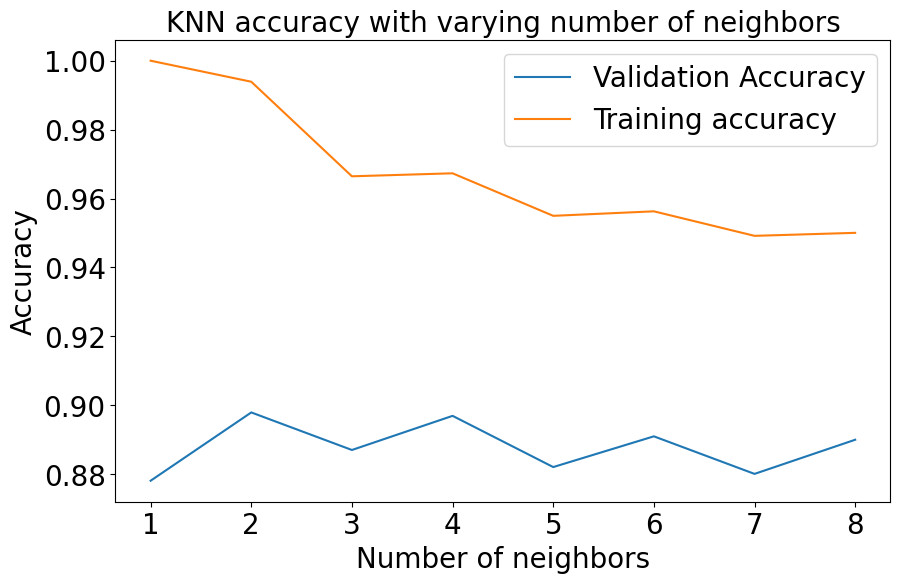

In [465]:
#plotting to see the results
plt.figure(figsize=(10,6))
plt.title('KNN accuracy with varying number of neighbors',fontsize=20)
plt.plot(neighbors, val_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend(prop={'size': 20})
plt.xlabel('Number of neighbors',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [466]:
#when n=5 tesing accurancy is higher
knn = KNeighborsClassifier(n_neighbors=4)

#Fit the model
knn.fit(X_train, y_train)

#Compute accuracy on the training set
train_accuracy[i] = knn.score(X_train, y_train)

#Compute accuracy on the test set
val_accuracy[i] = knn.score(X_val, y_val)

In [469]:
model = knn.fit(X_train, y_train)

In [470]:
y_pred = model.predict(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.8533687618349519

In [471]:
y_pred_proba = model.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

In [504]:
df_results_8 = pd.DataFrame()
df_results_8['y_pred'] = y_pred
df_results_8['y_true'] = y_val
df_results_8['predict_proba'] = y_pred_proba
df_results_8['average cost min'] = list(averagecostmin)
Profit_top_k(df_results_8)

2.9280190000000004

In [505]:
y_pred_proba_test = model.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [506]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_8.csv", index = False)